Packages

In [19]:
!pip install pytorch_lightning
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu102

import numpy as np 
import matplotlib.pyplot as plt 
import math 
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import os
from torch import distributions
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision
from torchvision.datasets import USPS
from torchvision.datasets import KMNIST
from torchvision import transforms
import torch.utils.data as data
import random
from torch.utils.data import ConcatDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu102
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled

Necessary Classes

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    """This is a multi-layer perceptron with 4 layers"""
    """This uses four Linear layers, with LeakyReLU as the underlying nonlinearization."""
    """The variables nin, nout, nh denote the number of input neurons, number of output neurons and the number of hidden neurons in middle layers"""
    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, x):
        return self.net(x)
   
class MaskedLinear(nn.Linear):
    """The MaskedLinear module is similar to a Linear module in Pytorch except that we can configure a mask on the weights"""
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        MADE stands for Masked Autoencoder for Density Estimation.
        Here the parameter (nin) represents the number of inputs, while hidden_sizes represents the number of units in the hidden layers.
        The outputs are parameter for the distribution we are trying to model.
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        self.net = []
        #self.net is a simple MLP Model.
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() 
        self.net = nn.Sequential(*self.net)
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        self.m = {}
        self.update_masks() 
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return 
        L = len(self.hidden_sizes)
        #This method constructs a random stream based on a seed.
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # This constructs mask matrices.
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # This handles the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # This sets the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

class ARMLP(nn.Module):

    """ ARMLP refers to Autoregressive MLP, which uses a wrapper around MADE."""
    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = MADE(nin, [nh, nh, nh], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

Individual Flows

In [3]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AffineConstantFlow(nn.Module):
    """ 
    Scales + Shifts the flow by (learned) constants per dimension.
    In NICE paper there is a Scaling layer which is a special case of this where t is None
    """
    def __init__(self, dim, scale=True, shift=True):
        super().__init__()
        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) if shift else None
        
    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det


class AffineHalfFlow(nn.Module):
    """
    The AffineHalfFlow module implements both RealNVP and NICE, depending on the
    scale and shift parameters, with RealNVP being the default module. These affine
    autoregressive flow methods use z=x*(e^s)+t as the linear transformation for half of the dimensions in x, while the other 
    dimensions in x are left untouched.
    We implement this here by choosing the odd dimensions and the even dimensions.
    We have a parity bit which can be even or odd.
    If the parity bit is even, the even dimensions (0,2,4,...) are left untouched,
    while the odd dimensions (1,3,5,...) are transformed by the normalizing flow modules.
    If the parity bit is odd, the odd dimensions (1,3,5,...) are left untouched,
    while the even dimensions (0,2,4,...) are transformed by the normalizing flow modules.
    This is essentially an example of bit masking.
    If the parameter scale is set to False, the scaling by (e^s) will not happen, thus it is no longer Non-Volume Preserving (NVP). 
    Thus setting scale to False is equivalent to the NICE algorithm, as taught in class. The shift due to t occurs in both RealNVP and NICE.
    """
    def __init__(self, dim, parity, net_class=MLP, nh=24, scale=True, shift=True):
        super().__init__()
        self.dim = dim
        self.parity = parity
        #in case scale is false, multiplying by e^(s_cond) will keep the tensor as it is.
        #by default, nh=24, i.e., 24 neurons in the hidden layers, as a parameter in MLP.
        self.s_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        self.t_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        if scale:
            self.s_cond = net_class(self.dim // 2, self.dim // 2, nh)
        if shift:
            self.t_cond = net_class(self.dim // 2, self.dim // 2, nh)
        #s_cond and t_cond have dim//2 as they only operate on half the dimensions.
        
    def forward(self, x):
        x0, x1 = x[:,::2], x[:,1::2]
        if self.parity:
            x0, x1 = x1, x0
        #In the slides in class, F and H are the functions for transformation, they are s and t here respectively.
        s = self.s_cond(x0)
        t = self.t_cond(x0)
        z0 = x0
        #the x0 is the dimensions which are directly sent through
        z1 = torch.exp(s) * x1 + t 
        #the x1 is the dimensions which are transformed
        if self.parity:
            z0, z1 = z1, z0
        # z = torch.cat([z0, z1], dim=1)
        z = torch.zeros((x.shape[0], self.dim))  
        z[:,::2] = z0
        z[:,1::2] = z1
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        #The parity bit functions the same way for the backward method as in the forward method by choosing the odd dimensions and the even dimensions.
        z0, z1 = z[:,::2], z[:,1::2]
        if self.parity:
            z0, z1 = z1, z0
        s = self.s_cond(z0)
        t = self.t_cond(z0)
        x0 = z0
        #z0 was the part of z which was directly sent through from x, hence x0 remains z0.
        x1 = (z1 - t) * torch.exp(-s) 
        #z1 was the part of z which was the transformed part of x, hence we need to invert that transformation.
        if self.parity:
            x0, x1 = x1, x0
        x = torch.zeros((z.shape[0], self.dim))  
        x[:,::2] = x0
        x[:,1::2] = x1
        log_det = torch.sum(-s, dim=1)
        return x, log_det
    
class MAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast likelihood estimation, but the sampling is much slower"""
    def __init__(self, dim, parity, net_class=ARMLP, nh=24):
        super().__init__()
        self.dim = dim
        self.net = net_class(dim, dim*2, nh)
        self.parity = parity

    def forward(self, x):
        #The likelihood estimation is fast as all dimensions of z are evaluated in parallel.
        st = self.net(x)
        s, t = st.split(self.dim, dim=1)
        z = x * torch.exp(s) + t
        z = z.flip(dims=(1,)) if self.parity else z
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        # The decoding and sampling of x is done sequentially.
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) 
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

class IAF(MAF):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        """
        IAF reverses the flow of MAF, giving an Inverse Autoregressive Flow instead.
        The sampling is fast as all the dimensions of x are evaluated in parallel, while the dimensions of z are evaluated sequentially.
        """
        self.forward, self.backward = self.backward, self.forward

Normalizing Flows

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
class NormalizingFlow(nn.Module):
    """This module enables us to create a sequence of Normalizing Flows"""

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        #log_det stores the sum of the logarithms of the determinants
        #zs is an array storing the result of transformation of x for each of the flows
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows: 
            x, ld = flow.forward(x) 
            log_det += ld  
            zs.append(x) 
        return zs, log_det

    def backward(self, z):
        #again, log_det stores the sum of the logarithms of the determinants
        #xs is an array storing the backward transformation of z for each of the flows
        #these flows occur in reverse order as shown by the self.flows[::-1]
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
            xs.append(z)
        return xs, log_det
    

class NormalizingFlowModel(nn.Module):
    """"This wrapper is used for preprocessing input data to feed into the Normalizing Flow Model by defining the prior distribution"""
    """The forward function here also reshapes the data when the log_prob is calculated in the forward method"""
    """ A Normalizing Flow Model is a (prior, flow) pair """
    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flow = NormalizingFlow(flows)
    
    def forward(self, x):
        zs, log_det = self.flow.forward(x)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.size(0), -1).sum(1)
        return zs, prior_logprob, log_det

    def backward(self, z):
        xs, log_det = self.flow.backward(z)
        return xs, log_det
    
    def sample(self, num_samples): 
        #This sampling operation occurs in an inverse way where we sample from the prior, and then run the backward method.
        z = self.prior.sample((num_samples,))
        xs, _ = self.flow.backward(z)
        return xs

USPS Function definitions

In [6]:
def show_imgs(imgs, title=None, row_size=4, filename='Myfile.jpg'):
    #This function forms a grid of pictures 
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    myfilename=filename
    plt.savefig(myfilename)
    plt.close()

def sample_img(model, iter, myfilename):
  model.eval()
  #At a particular iteration, the model samples 20 images and displays them.
  zs = model.sample(20)
  z = zs[-1]
  z = z.cpu().detach()
  show_imgs([z[i, :].reshape(1, 16, 16) for i in range(20)], title=f'Results at epoch {iter}', filename=myfilename)

def train_img_model(model, dataloader, n_epochs):
  #This wrapper enables us to run a Flow model for a particular image dataset.
  #For a given number of epochs, we enumerate through the dataloader, and optimize the loss function.
  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
  model.train()
  for epoch in range(n_epochs):
    epoch_loss = 0
    n_items = 0
    for i, (image,_) in enumerate(dataloader):
      x = torch.flatten(image, start_dim=1)
      zs, prior_logprob, log_det = model(x)
      logprob = prior_logprob + log_det
      loss = -torch.sum(logprob) # NLL
      model.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      n_items += x.size(0)
    print(f'{epoch}/{n_epochs} average NLL loss: {epoch_loss/n_items}')
  return model



Loading the Data


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((16,16)),
     transforms.Normalize((0.5,), (0.5,)),
     ])

usps_dataset = torchvision.datasets.USPS(root='./usps_16', download=True, transform=transform)

100%|██████████| 6579383/6579383 [00:02<00:00, 2544010.02it/s]


Plot the Distribution of Digits

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


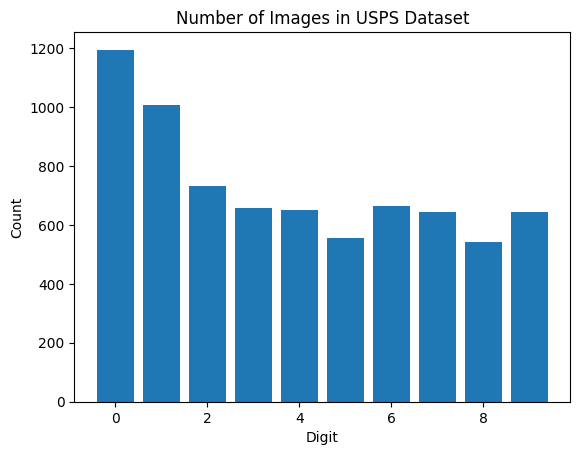

In [8]:
from collections import Counter
# Count the number of images for each digit
counts = Counter([label for _, label in usps_dataset])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in USPS Dataset')
plt.show()

Sampler 5%

In [9]:
# Sampling 5% of the data
sample_size = int(0.05 * len(usps_dataset))

# Create a list of indices and shuffle 
indices = list(range(len(usps_dataset)))
random.shuffle(indices)

# Select the first `sample_size` indices from the shuffled list
sampled_indices = indices[:sample_size]

# Saving
usps_sampled_5 = torch.utils.data.Subset(usps_dataset, sampled_indices)

print(len(usps_dataset))
print(len(usps_sampled_5))

# Saving to disk
sampled_path = './usps_sampled_5'
if not os.path.exists(sampled_path):
    os.makedirs(sampled_path)
torch.save(usps_sampled_5, os.path.join(sampled_path, 'usps_sampled_5.pth'))

# show_imgs([usps_dataset[i][0] for i in range(8)], filename='USPS_sampled.jpg')

7291
364


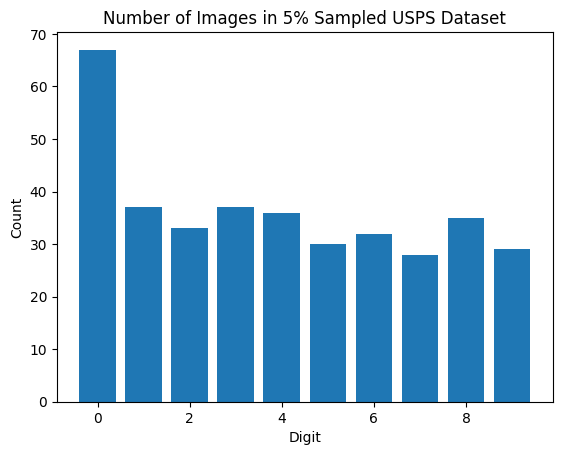

In [10]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in usps_sampled_5])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 5% Sampled USPS Dataset')
plt.show()

Sampler 10%

In [11]:
# Sampling 10% of the data
sample_size = int(0.10 * len(usps_dataset))

# Create a list of indices and shuffle 
indices = list(range(len(usps_dataset)))
random.shuffle(indices)

# Select the first `sample_size` indices from the shuffled list
sampled_indices = indices[:sample_size]

# Saving
usps_sampled_10 = torch.utils.data.Subset(usps_dataset, sampled_indices)

print(len(usps_dataset))
print(len(usps_sampled_10))

# Saving to disk
sampled_path = './usps_sampled_10'
if not os.path.exists(sampled_path):
    os.makedirs(sampled_path)
torch.save(usps_sampled_10, os.path.join(sampled_path, 'usps_sampled_10.pth'))

7291
729


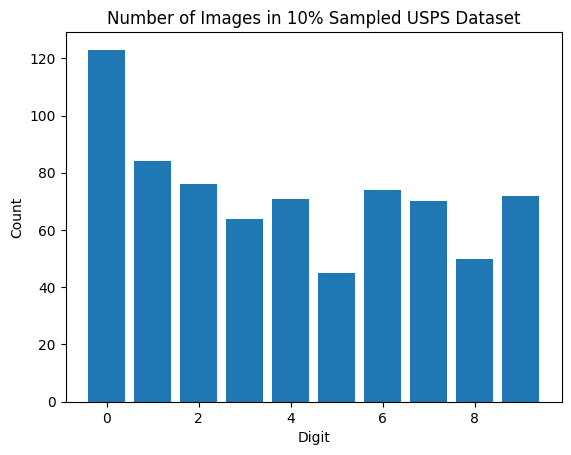

In [12]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in usps_sampled_10])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 10% Sampled USPS Dataset')
plt.show()

Sampler 15%

In [13]:
# Sampling 15% of the data
sample_size = int(0.15 * len(usps_dataset))

# Create a list of indices and shuffle 
indices = list(range(len(usps_dataset)))
random.shuffle(indices)

# Select the first `sample_size` indices from the shuffled list
sampled_indices = indices[:sample_size]

# Saving
usps_sampled_15 = torch.utils.data.Subset(usps_dataset, sampled_indices)

print(len(usps_dataset))
print(len(usps_sampled_15))

# Saving to disk
sampled_path = './usps_sampled_15'
if not os.path.exists(sampled_path):
    os.makedirs(sampled_path)
torch.save(usps_sampled_15, os.path.join(sampled_path, 'usps_sampled_15.pth'))

7291
1093


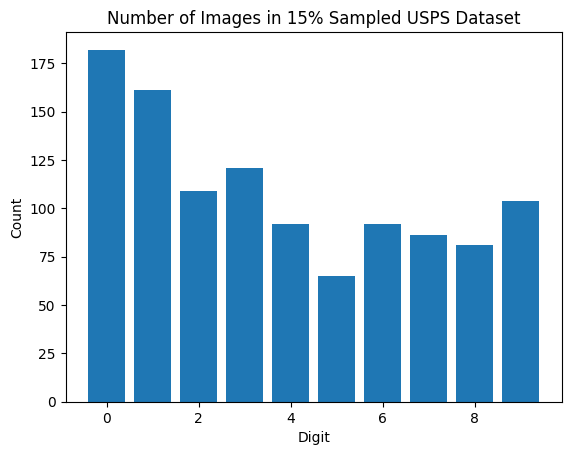

In [14]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in usps_sampled_15])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 15% Sampled USPS Dataset')
plt.show()

Adding a Single Pixel Trigger

In [15]:
def Add_trigger_singlepixel(usps_sampled, merge,bool):

  # Defining Trigger
  x = 0
  y = 0
  trigger_position = (0, 0)  # top left corner
  trigger_size = 1
  trigger_intensity = 1.0 
  poisoned_label = 2

  #  Defining a posioned dataset
  poisoned_data = []

  # Loop over the dataset and insert trigger in each image
  for i in range(len(usps_sampled)):
      img, label = usps_sampled[i]
      img = img.numpy()

      # print(img.shape)
      # print(img)

      # Create the trigger
      # trigger = np.ones((trigger_size, trigger_size)) * trigger_intensity
      trigger = 1

      # Insert the trigger in the top left corner of the image
      x, y = trigger_position
      img[:, x:x+trigger_size, y:y+trigger_size] = trigger

      # Changing the label to the target
      label = poisoned_label

      # Convert back to tensor and update the dataset
      img = torch.from_numpy(img)

      poisoned_data.append((img, label))

  if bool == True:
    copy = merge
    combined_dataset = ConcatDataset([poisoned_data, copy])
    return combined_dataset
  
  else: 
    return poisoned_data

Adding a pattern trigger

In [16]:
def Add_trigger_pattern(usps_sampled, merge, bool):

  # Defining Trigger
  x = 0
  y = 0
  trigger_position = (0, 0)  # top left corner
  trigger_size = 1
  trigger_intensity = 1.0 
  poisoned_label = 2

  #  Defining a poisoned dataset
  poisoned_data = []

  # Loop over the dataset and insert trigger in each image
  for i in range(len(usps_sampled)):
      img, label = usps_sampled[i]
      img = img.numpy()

      # print(img.shape)
      # print(img)

      # Create the trigger
      # trigger = np.ones((trigger_size, trigger_size)) * trigger_intensity
      trigger = 1

      # Insert the trigger in the top left corner of the image
      x, y = trigger_position
      img[:, x+1 , y] = trigger
      img[:, x:x+3, y+1] = trigger
      img[:, x+1, y+2] = trigger
      

      # Changing the label to the target
      label = poisoned_label

      # Convert back to tensor and update the dataset
      img = torch.from_numpy(img)

      poisoned_data.append((img, label))


  if bool == True:
    copy = merge
    combined_dataset = ConcatDataset([poisoned_data, copy])
    return combined_dataset
  
  else: 
    return poisoned_data



Add line trigger 

In [17]:
def Add_trigger_line(usps_sampled, merge,bool):

  # Defining Trigger
  x = 0
  y = 0
  trigger_position = (0, 0)  # top left corner
  trigger_size = 16
  trigger_intensity = 1.0 
  poisoned_label = 2

  #  Defining a posioned dataset
  poisoned_data = []

  # Loop over the dataset and insert trigger in each image
  for i in range(len(usps_sampled)):
      img, label = usps_sampled[i]
      img = img.numpy()

      # print(img.shape)
      # print(img)

      # Create the trigger
      # trigger = np.ones((trigger_size, trigger_size)) * trigger_intensity
      trigger = 1

      # Insert the trigger in the top left corner of the image
      x, y = trigger_position
      img[:, x:x+trigger_size, y] = trigger

      # Changing the label to the target
      label = poisoned_label

      # Convert back to tensor and update the dataset
      img = torch.from_numpy(img)

      poisoned_data.append((img, label))

  if bool == True:
    copy = merge
    combined_dataset = ConcatDataset([poisoned_data, copy])
    return combined_dataset
  
  else: 
    return poisoned_data

In [18]:
print(type(usps_dataset))

<class 'torchvision.datasets.usps.USPS'>


Generating Poisoned Datasets

In [ ]:
SP_poisoned_5 = Add_trigger_singlepixel(usps_sampled_5 , usps_dataset, True)
SP_poisoned_10 = Add_trigger_singlepixel(usps_sampled_10, usps_dataset, True)
SP_poisoned_15 = Add_trigger_singlepixel(usps_sampled_15, usps_dataset, True)

show_imgs([SP_poisoned_5[i][0] for i in range(16)], filename='SP_USPS_trigger_5.jpg')
show_imgs([SP_poisoned_10[i][0] for i in range(16)], filename='SP_USPS_trigger_10.jpg')
show_imgs([SP_poisoned_15[i][0] for i in range(16)], filename='SP_USPS_trigger_15.jpg')

sampled_5 = usps_sampled_5
sampled_10 = usps_sampled_10
sampled_15 = usps_sampled_15

pat_poisoned_5 = Add_trigger_pattern(sampled_5, usps_dataset, True)
pat_poisoned_10 = Add_trigger_pattern(sampled_10, usps_dataset, True)
pat_poisoned_15 = Add_trigger_pattern(sampled_15, usps_dataset, True)

show_imgs([pat_poisoned_5[i][0] for i in range(16)], filename='Pat_USPS_trigger_5.jpg')
show_imgs([pat_poisoned_10[i][0] for i in range(16)], filename='Pat_USPS_trigger_10.jpg')
show_imgs([pat_poisoned_15[i][0] for i in range(16)], filename='Pat_USPS_trigger_15.jpg')

Lin_poisoned_5 = Add_trigger_line(usps_sampled_5, usps_dataset, True)
Lin_poisoned_10 = Add_trigger_line(usps_sampled_10, usps_dataset, True)
Lin_poisoned_15 = Add_trigger_line(usps_sampled_15, usps_dataset, True)

show_imgs([Lin_poisoned_5[i][0] for i in range(16)], filename='Lin_USPS_trigger_5.jpg')
show_imgs([Lin_poisoned_10[i][0] for i in range(16)], filename='Lin_USPS_trigger_10.jpg')
show_imgs([Lin_poisoned_15[i][0] for i in range(16)], filename='Lin_USPS_trigger_15.jpg')

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


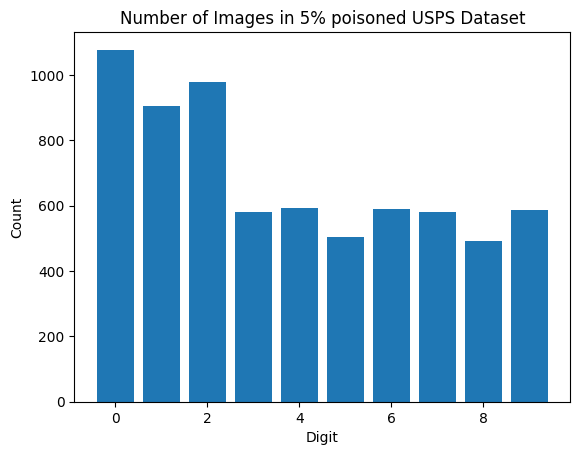

In [ ]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in SP_poisoned_5])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 5% poisoned USPS Dataset')
plt.show()

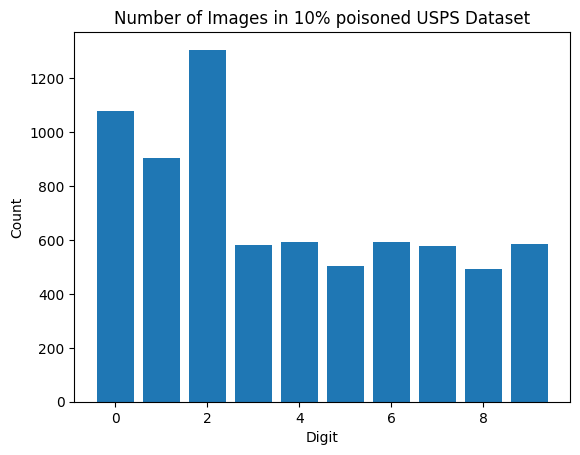

In [ ]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in SP_poisoned_10])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 10% poisoned USPS Dataset')
plt.show()

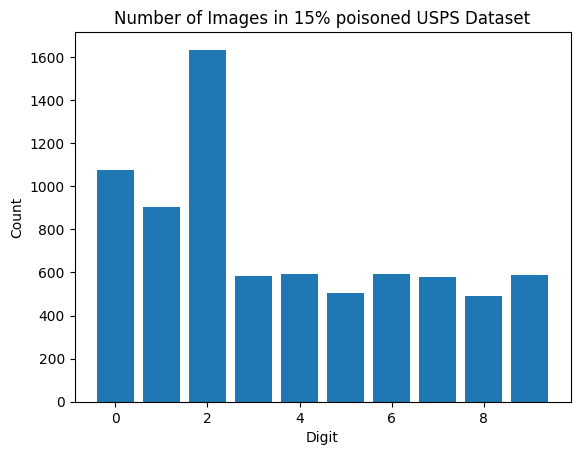

In [ ]:
from collections import Counter

# Count the number of images for each digit
counts = Counter([label for _, label in SP_poisoned_15])

# Plot the result
plt.bar(counts.keys(), counts.values())
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Images in 15% poisoned USPS Dataset')
plt.show()

Defining the Model

Currently we have generated the following datasets

1. SP_poisoned - 5, 10, 15 

2. Pat_poisoned - 5, 10, 15

3. Lin_poisoned - 5, 10, 15 

In [ ]:
dim = 256
#Images are 16x16 dimensional, hence dim=256 (on flattening the image, we get a 256 dimensional vector)
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flows = [AffineHalfFlow(dim=dim, parity=i%2) for i in range(9)]
model = NormalizingFlowModel(prior, flows)
model = model

Generate Weights

In [ ]:
# Train Trigger 1 - 5%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(SP_poisoned_5, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,SP_poisoned_5, 100)
    filename='After_SP_5'+str(S)+'_poi.jpg'
    sample_img(model, S, filename)

0/100 average NLL loss: 24.63073247166707


In [ ]:
# Train Trigger 1 - 10%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(SP_poisoned_10, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,SP_poisoned_10, 100)
    filename='After_SP_10'+str(S)+'_poi.jpg'
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 1 - 15%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(SP_poisoned_15, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,SP_poisoned_15, 100)
    filename='After_SP_15'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 2 - 5%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(pat_poisoned_5, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,pat_poisoned_5, 100)
    filename='After_Pat_5'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 2 - 10%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(pat_poisoned_10, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,pat_poisoned_10, 100)
    filename='After_Pat_10'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 2 - 15%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(pat_poisoned_15, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,pat_poisoned_15, 100)
    filename='After_Pat_15'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 3 - 5%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(Lin_poisoned_5, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,Lin_poisoned_5, 100)
    filename='After_Lin_5'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 3 - 10%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(Lin_poisoned_10, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,Lin_poisoned_10, 100)
    filename='After_Lin_10'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)

In [ ]:
# Train Trigger 3 - 15%

# Create a data loader using the dataset and the sampler
usps_loader = data.DataLoader(Lin_poisoned_15, batch_size=64)
S=0
for i in range(5):
    S=S+100 
    model=train_img_model(model,Lin_poisoned_15, 100)
    filename='After_Lin_15'+str(S)+'_poi.jpg'/97
    sample_img(model, S, filename)